<a href="https://colab.research.google.com/github/ksp7273/ESNN-Classification/blob/main/classification_openai_evolution_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Evolution Strategies to train neural networks

We will implement evolution strategies to train a neural network that will classify a dataset.

Our algorithm is based off this blog post from OpenAI:
https://openai.com/blog/evolution-strategies/

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, Y = make_moons(noise=0.15, random_state=1, n_samples=500)

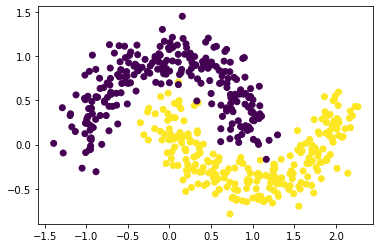

In [5]:
plt.scatter(X[:,0], X[:,1], c=Y)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state = 42)
X_train, X_test, y_train, y_test = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.LongTensor(y_train), torch.LongTensor(y_test)

In [8]:
n_input_dim = X_train.shape[-1]
n_input_dim # should be 2

2

In [9]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    m.weight.data.normal_(0.0, 0.02)

In [10]:
model = nn.Sequential(
    nn.Linear(n_input_dim, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 2),
    nn.Sigmoid()
)
model = model.float()
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=2, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=2, bias=True)
  (5): Sigmoid()
)

In [11]:
_ = model(X_train) # make sure it works

In [12]:
# now, implementing the training algorithm
mother_parameters = model.parameters()
mother_vector = nn.utils.parameters_to_vector(mother_parameters)
mother_vector.shape

torch.Size([982])

In [13]:
# Fitness function
loss_func = nn.CrossEntropyLoss()
def loss(y_pred, y_true):
  return 1/loss_func(y_pred, y_true) # we are maximizing the loss in ES, so take the reciprocal
  # now, increasing loss means the model is learning

In [14]:
def fitness_func(solution):
  # solution is a vector of paramters like mother_parametrs
  nn.utils.vector_to_parameters(solution, model.parameters())
  return loss(model(X_train), y_train) + 0.00000001

In [15]:
# in ES, our population is a slightly altered version of the mother parameters, so we implement a jitter function
def jitter(mother_params, state_dict):
  params_try = mother_params + SIGMA*state_dict # we will intiialize SIGMA later
  return params_try

In [16]:
# now, we calculate the fitness of entire population
def calculate_population_fitness(pop, mother_vector):
  fitness = torch.zeros(pop.shape[0])
  for i, params in enumerate(pop):
    p_try = jitter(mother_vector, params)
    fitness[i] = fitness_func(p_try)
  return fitness

In [17]:
def test(mother_params):
  nn.utils.vector_to_parameters(mother_params, model.parameters())
  return (((torch.max(model(X_test), 1)[1] == y_test).sum())/len(y_test)).item()
  # calculates the test accuracy of model

In [18]:
# Now, for the hyperparameters like sigma
SIGMA = 0.01
LR = 0.001
POPULATION_SIZE=50
ITERATIONS = 500 # 500 should be more than enough

In [19]:
n_params = nn.utils.parameters_to_vector(model.parameters()).shape[0]
print(f"Number of params: {n_params}")

Number of params: 982


In [20]:
from tqdm.notebook import tqdm

In [21]:
# Now, we train the model
with torch.no_grad(): #autograd makes it slower + takes more memory. We dont use differnetiation in ES
  for iteration in tqdm(range(ITERATIONS)):
    pop = torch.from_numpy(np.random.randn(POPULATION_SIZE, n_params)).float()
    fitness = calculate_population_fitness(pop, mother_vector)
    # normalize the fitness
    normalized_fitness = (fitness - torch.mean(fitness)) / torch.std(fitness)
    # update mother vector with the fitness values
    mother_vector = mother_vector + (LR / (POPULATION_SIZE * SIGMA)) * torch.matmul(pop.t(), normalized_fitness)
    if iteration % 50 == 0:
      reward = fitness_func(mother_vector)
      acc = test(mother_vector)
      print(f"Iteration: {iteration}, Reward:{reward}, Accuracy: {acc * 100}")

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0, Reward:1.4434609413146973, Accuracy: 47.647058963775635
Iteration: 50, Reward:2.3504135608673096, Accuracy: 84.70588326454163
Iteration: 100, Reward:2.4135947227478027, Accuracy: 88.23529481887817
Iteration: 150, Reward:2.495849370956421, Accuracy: 89.99999761581421
Iteration: 200, Reward:2.642674207687378, Accuracy: 92.9411768913269
Iteration: 250, Reward:2.834954261779785, Accuracy: 97.64705896377563
Iteration: 300, Reward:2.9079172611236572, Accuracy: 97.64705896377563
Iteration: 350, Reward:2.9673357009887695, Accuracy: 98.23529124259949
Iteration: 400, Reward:2.9796526432037354, Accuracy: 98.23529124259949
Iteration: 450, Reward:2.980787754058838, Accuracy: 97.64705896377563


In [22]:
# lets test model
preds = model(X_test)
_, preds_classes = torch.max(preds, 1)

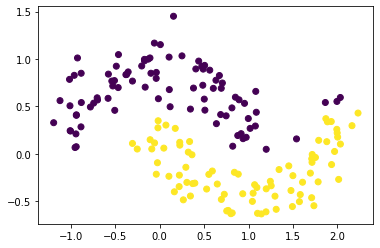

In [23]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds_classes.detach().numpy())